In [1]:
from OpInf import *
import numpy as np
import scipy
import umap
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from typing import Tuple, List, Dict, Any, NewType

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from itertools import product, combinations

from sklearn.manifold import SpectralEmbedding

from pathlib import Path
from tqdm import tqdm
import json
import stiefel

from stiefel import *
import importlib
importlib.reload(stiefel)

from Representation import *

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots
plt.style.use(["science", "grid"])
# plt.style.use(["science", "grid"])
plt.rcParams.update({
    "font.size": 20,
}
)

# set numpy random seed
np.random.seed(3)


2024-10-24 13:50:54.053418: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 13:50:54.062759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 13:50:54.072734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 13:50:54.075700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 13:50:54.083785: I tensorflow/core/platform/cpu_feature_guar

check syl solve
True
here
True
6.114579112191741e-14
Use algebraic Stiefel log, metric alpha =  -0.0
dist 3.769911184307759
NORM TEST1: 0.0
NORM TEST2: 1.5765173454890258e-12
NORM TEST3: 7.539541907464198e-15


In [2]:
torch.cuda.is_available()

True

In [3]:
def initial_condition(mu, coord):
    if coord <= 0.5:
        return mu * np.sin(2 * np.pi * coord)
    
    return 0

In [4]:
# mus = [1.1, 1.05, 1, 0.95, 0.9]
# mus = [1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85]
# mus = [0.4, 0.6, 0.8, 1.0, 1.2]
mus = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
# Load data
T_end_train = 2 
T_end = 2
dt= 1e-3
Train_T = int(T_end_train/dt)
T_end_index = int(T_end/dt)

# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :Train_T+1, :]
# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu1.15_0.85.npy")[:, :Train_T+1, :]
# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu04_12.npy")[:, :Train_T+1, :]
# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu0.4_0.1_1.2.npy")[:, :Train_T+1, :]
# X_all_test = np.load("../examples/burgers/burgersFEniCSx_u_sol_RE1000_mu0.98.npy")[0]

X_all_nominal = np.load("/data1/jy384/research/Data/UnimodalSROB/burgers/burgersFEniCSx_u_sol_all_RE1000_mu0.4_0.1_1.2_256.npy")[:, :Train_T+1, :]
X_all_test = np.load("/data1/jy384/research/Data/UnimodalSROB/burgers/burgersFEniCSx_u_sol_RE1000_mu0.98_256.npy")[0]

In [5]:
p = 2
Mp = len(mus)
dt = 1e-3

config = {
    # "N": 2**7 + 1 + 1,
    "N": 2**8 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "4c",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [6]:
# create simple torch neural network
class Net(nn.Module):
    def __init__(self, r: int, p: int, dim: int = 50):
        super(Net, self).__init__()
        """Simple neural network with 5 hidden layers.
        r is the first r columns of basis matrix V
        p is the next p columns of basis matrix V from r

        Args:
            r (int): Number of first r columns of basis matrix V
            p (int): Number of next p columns of basis matrix V from r
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(r, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.fc3 = nn.Linear(dim, dim)
        self.fc4 = nn.Linear(dim, dim)
        self.fc5 = nn.Linear(dim, p)        
        
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = F.silu(self.fc3(x))
        x = F.silu(self.fc4(x))
        x = self.fc5(x)
            
        return x

In [7]:
# a colors list to tag the group of combinations
colors = plt.get_cmap('tab20').colors

# Create a dictionary to store combinations with their respective colors
tagged_combinations = {}

for r in range(1, len(mus) - 1):
    combinations_ = list(combinations(mus[1:-1], r))
    combinations_ = [(mus[0],) + combo + (mus[-1],) for combo in combinations_]
    print(f"{len(combinations_)} of combinations generated: ", combinations_)
    
    # Ensure that there are enough colors, cycle through colors if necessary
    color = colors[(r - 1) % len(colors)]
    
    # Store the combinations with their tag
    tagged_combinations[color] = combinations_
    
# Flatten the list and maintain the color tagging
flattened_tagged_combinations = [(item, color) for color, combos in tagged_combinations.items() for item in combos]

# Example of accessing the flattened list with color tags
for combo, color in flattened_tagged_combinations:
    print(f"Combination: {combo}, Color: {color}")

7 of combinations generated:  [(0.4, 0.5, 1.2), (0.4, 0.6, 1.2), (0.4, 0.7, 1.2), (0.4, 0.8, 1.2), (0.4, 0.9, 1.2), (0.4, 1.0, 1.2), (0.4, 1.1, 1.2)]
21 of combinations generated:  [(0.4, 0.5, 0.6, 1.2), (0.4, 0.5, 0.7, 1.2), (0.4, 0.5, 0.8, 1.2), (0.4, 0.5, 0.9, 1.2), (0.4, 0.5, 1.0, 1.2), (0.4, 0.5, 1.1, 1.2), (0.4, 0.6, 0.7, 1.2), (0.4, 0.6, 0.8, 1.2), (0.4, 0.6, 0.9, 1.2), (0.4, 0.6, 1.0, 1.2), (0.4, 0.6, 1.1, 1.2), (0.4, 0.7, 0.8, 1.2), (0.4, 0.7, 0.9, 1.2), (0.4, 0.7, 1.0, 1.2), (0.4, 0.7, 1.1, 1.2), (0.4, 0.8, 0.9, 1.2), (0.4, 0.8, 1.0, 1.2), (0.4, 0.8, 1.1, 1.2), (0.4, 0.9, 1.0, 1.2), (0.4, 0.9, 1.1, 1.2), (0.4, 1.0, 1.1, 1.2)]
35 of combinations generated:  [(0.4, 0.5, 0.6, 0.7, 1.2), (0.4, 0.5, 0.6, 0.8, 1.2), (0.4, 0.5, 0.6, 0.9, 1.2), (0.4, 0.5, 0.6, 1.0, 1.2), (0.4, 0.5, 0.6, 1.1, 1.2), (0.4, 0.5, 0.7, 0.8, 1.2), (0.4, 0.5, 0.7, 0.9, 1.2), (0.4, 0.5, 0.7, 1.0, 1.2), (0.4, 0.5, 0.7, 1.1, 1.2), (0.4, 0.5, 0.8, 0.9, 1.2), (0.4, 0.5, 0.8, 1.0, 1.2), (0.4, 0.5, 0.8, 1.1, 1.2), 

/tmp/ipykernel_1816483/233316870.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


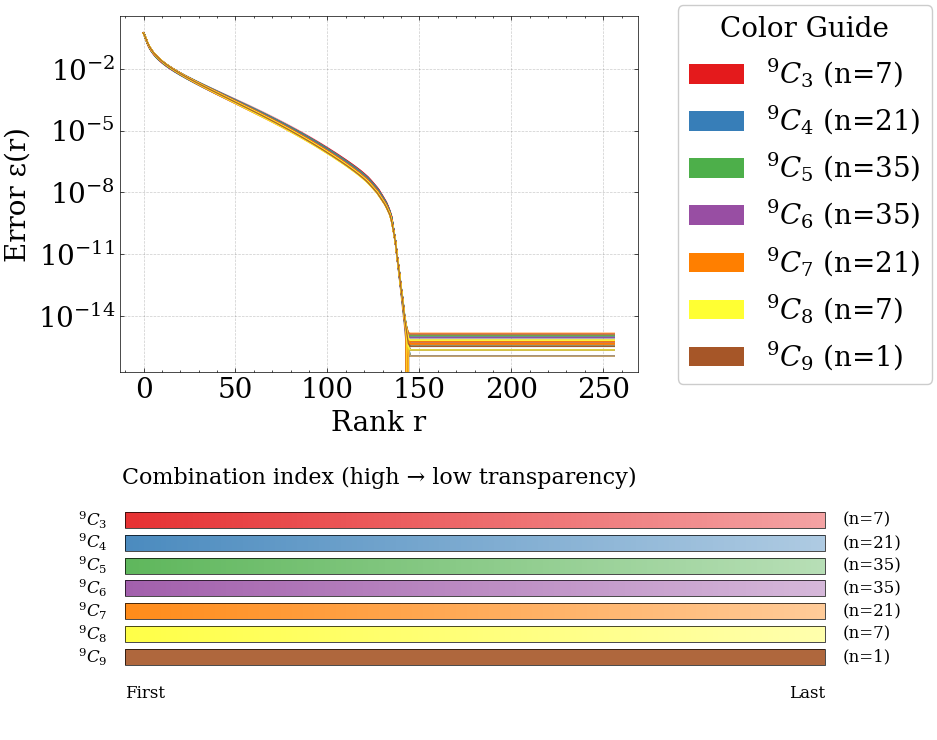

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.colors import to_rgba, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable

def plot_svd_decay_with_groups(X_list, drawn_mus, err_tol=5e-2):
    """
    Plot SVD decay with horizontal colorbars showing transparency gradients.
    """
    # Create figure with main plot and space for colorbars
    fig = plt.figure(figsize=(10, 8))
    gs = plt.GridSpec(2, 1, height_ratios=[3, 2])
    ax_main = fig.add_subplot(gs[0])
    ax_guide = fig.add_subplot(gs[1])
    
    # Create color scheme for different combination sizes
    n_groups = len(set(len(mu) for mu in drawn_mus))
    base_colors = plt.cm.Set1(range(n_groups))
    
    # Create a mapping of combination size to color and prepare group information
    color_map = {}
    group_info = {}
    for i, size in enumerate(sorted(set(len(mu) for mu in drawn_mus))):
        color_map[size] = base_colors[i]
        group_info[size] = {
            'color': base_colors[i],
            'count': len([mu for mu in drawn_mus if len(mu) == size])
        }
    
    # Plot SVD decay curves
    for i, (X, mus) in enumerate(zip(X_list, drawn_mus)):
        X_ref = np.mean(X, axis=1)[:, None]
        U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
        eigvals_SVD = S**2 * (1 / (len(S) - 1))
        rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
        
        base_color = color_map[len(mus)]
        same_size_combinations = [mu for mu in drawn_mus if len(mu) == len(mus)]
        alpha = 0.9 - (0.5 * same_size_combinations.index(mus) / len(same_size_combinations))
        
        color_with_alpha = to_rgba(base_color, alpha)
        ax_main.plot(rel_err_SVD, color=color_with_alpha, linewidth=1)
    
    # Customize main plot
    ax_main.set_yscale('log')
    ax_main.set_ylabel("Error ε(r)")
    ax_main.grid(True, alpha=0.2)
    ax_main.set_xlabel("Rank r")
    
    max_size = max(group_info.keys())
    
    # Create group-level legend
    legend_elements = []
    for size, info in group_info.items():
        legend_elements.append(
            Rectangle((0, 0), 1, 1, facecolor=info['color'],
                     label=f'$^{max_size}C_{size}$ (n={info["count"]})')
        )
        
    ax_main.legend(handles=legend_elements, 
                  title="Color Guide",
                  loc='center left', 
                  bbox_to_anchor=(1.05, 0.5))
    
    # Create horizontal colorbars
    ax_guide.set_title("Combination index (high → low transparency)", pad=10, fontsize=16)
    
    # Calculate positions for colorbars
    n_groups = len(group_info)
    bar_height = 0.2 / n_groups
    
    # Remove existing axes
    ax_guide.set_frame_on(False)
    ax_guide.set_xticks([])
    ax_guide.set_yticks([])
    
    for i, (size, info) in enumerate(sorted(group_info.items(), reverse=True)):
        # Create colormap that goes from high to low alpha
        base_color = info['color']
        
        # Create colormap - single color for n=1, gradient otherwise
        colors = [to_rgba(base_color[:3], 0.9)] * 2 if info['count'] == 1 else [to_rgba(base_color[:3], alpha) for alpha in [0.9, 0.4]]
        cmap = LinearSegmentedColormap.from_list(f'custom_{size}', colors)
        
        # Create axes for this colorbar
        cax_pos = [0.15, 0.125 + i * bar_height, 0.7, bar_height * 0.7]  # [left, bottom, width, height]
        cax = fig.add_axes(cax_pos)
        
        # Create colorbar
        norm = plt.Normalize(0, 1)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', ticks=[])
        
        # Add labels
        cax.text(-0.025, 0.5, f"$^{max_size}C_{size}$",
                ha='right', va='center', transform=cax.transAxes, fontsize=12)
        cax.text(1.025, 0.5, f"(n={info['count']})", 
                ha='left', va='center', transform=cax.transAxes, fontsize=12)
    
    # Create a new axis for First/Last labels at the bottom
    # Adjusted position: moved lower by increasing the negative offset
    label_ax_pos = [0.15, 0.125 - 1.5 * bar_height, 0.7, bar_height * 0.5]  # Increased negative offset
    label_ax = fig.add_axes(label_ax_pos)
    label_ax.set_frame_on(False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    
    # Add First/Last labels with adjusted vertical position
    label_ax.text(0, 0.5, 'First', ha='left', va='center', fontsize=12)
    label_ax.text(1, 0.5, 'Last', ha='right', va='center', fontsize=12)
    
    plt.tight_layout()
    return fig

X_nominal = np.concatenate([X for X in X_all_nominal], axis=0).T

# randomly draw 3 ICs (mus) without replacement from X_all_nominal
# X_all_nominals_lst = [X_all_nominal, X_all_nominal_2]
X_list = []
drawn_mus = [tup[0] for tup in flattened_tagged_combinations]
color_tags = []
for n_X in range(len(flattened_tagged_combinations)):
    mus_idx = [mus.index(mus_) for mus_ in flattened_tagged_combinations[n_X][0]]
    # print(mus_idx)
    color_tags.append(flattened_tagged_combinations[n_X][1])
    X_list.append(np.concatenate([X_all_nominal[i] for i in mus_idx], axis=0).T)

# X_list.append(X_nominal)
# color_tags.append((0,1,1)) # cyan

rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
# names = [f"tap={taps}" for taps in numtaps] + ["Nominal"]
names = [f"$\mu$={mus}" for i, mus in enumerate(drawn_mus)]

# Example usage:
plt.rc('text', usetex=False)
fig = plot_svd_decay_with_groups(X_list, drawn_mus)
plt.savefig("errorFunc_all_grouped_publication.pdf", bbox_inches='tight', dpi=300)

X =  (257, 6003)
X_ref =  (257, 1)
S =  [165.26797857 128.5916006   98.48264517  64.34244432  45.8191234 ]
idx =  7
rel_err_SVD[idx] =  0.03451765220374681
X =  (257, 6003)
X_ref =  (257, 1)
S =  [169.16588958 126.00022665 100.04889584  66.34007544  48.32450489]
idx =  7
rel_err_SVD[idx] =  0.03650749824756505
X =  (257, 6003)
X_ref =  (257, 1)
S =  [175.18171515 126.15792571 101.85516731  67.94445987  49.4733337 ]
idx =  7
rel_err_SVD[idx] =  0.038522826377843655
X =  (257, 6003)
X_ref =  (257, 1)
S =  [181.89788553 129.04536351 103.95386703  69.91469605  50.65876834]
idx =  7
rel_err_SVD[idx] =  0.03863772898371731
X =  (257, 6003)
X_ref =  (257, 1)
S =  [188.42735207 133.78569541 106.24892494  71.74608666  51.83180406]
idx =  7
rel_err_SVD[idx] =  0.03847583887931638
X =  (257, 6003)
X_ref =  (257, 1)
S =  [194.7174688  139.7664043  108.9131675   73.50311156  53.01341848]
idx =  7
rel_err_SVD[idx] =  0.03813516783599169
X =  (257, 6003)
X_ref =  (257, 1)
S =  [200.7687983  146.67574

KeyboardInterrupt: 

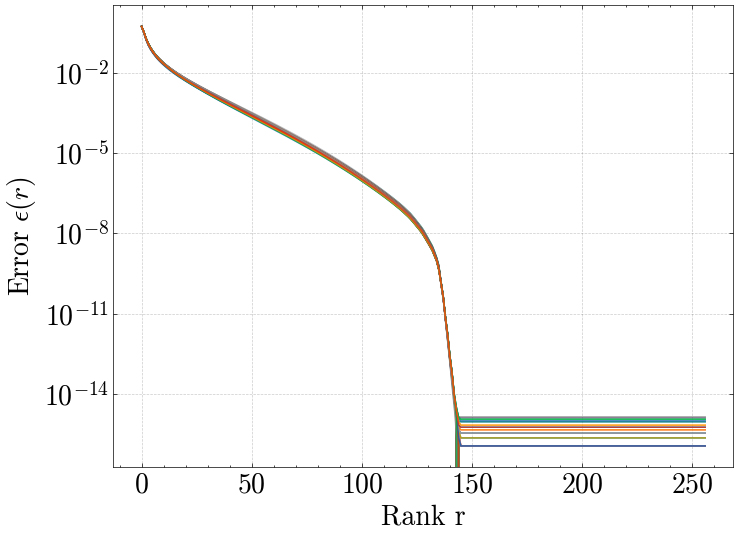

In [9]:
X_nominal = np.concatenate([X for X in X_all_nominal], axis=0).T

# randomly draw 3 ICs (mus) without replacement from X_all_nominal
# X_all_nominals_lst = [X_all_nominal, X_all_nominal_2]
X_list = []
drawn_mus = [tup[0] for tup in flattened_tagged_combinations]
color_tags = []
for n_X in range(len(flattened_tagged_combinations)):
    mus_idx = [mus.index(mus_) for mus_ in flattened_tagged_combinations[n_X][0]]
    # print(mus_idx)
    color_tags.append(flattened_tagged_combinations[n_X][1])
    X_list.append(np.concatenate([X_all_nominal[i] for i in mus_idx], axis=0).T)

# X_list.append(X_nominal)
# color_tags.append((0,1,1)) # cyan

rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
# names = [f"tap={taps}" for taps in numtaps] + ["Nominal"]
names = [f"$\mu$={mus}" for i, mus in enumerate(drawn_mus)]

fig, ax = plt.subplots(figsize=(8, 6))

err_tol = 5e-2

# mus = [0.01] # only one mu for now

for i in range(len(X_list)):
    
    X = X_list[i]
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    # ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol:.2e} at r={idx}, {names[i]}")
    ax.set_yscale('log')
    ax.set_ylabel("Error $\\epsilon(r)$")
    # set limit
    # ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    # ax.set_title("Relative error, RE1000")
    # ax.legend()
    
plt.savefig("errorFunc_all.pdf", bbox_inches='tight')

In [9]:
# Model parameters
# r = idx_lst[-1]
r = min(idx_lst)
# q_trunc = 2
# q_trunc = 2
q_trunc = 8
# p = 3

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.01       # regularization parameter\
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

for i in range(len(X_list)):
    # Procustes problem for each mu
    X = X_list[i]
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    print("X = ", X.shape)
    X_ref = np.mean(X, axis=1)[:, None]
    # X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r + q_trunc]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    energy = np.linalg.norm(Vr @ q + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(X - X_ref, 'fro')**2
    
    print(f"Snapshot energy: {energy:e}")

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)

    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q, p, initial_Shat=None)

    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.659786e-01

Reconstruction error: 18.4448%
num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.642321e-01

Reconstruction error: 18.9123%
num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.623957e-01

Reconstruction error: 19.3917%
num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.622795e-01

Reconstruction error: 19.4216%
num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.625440e-01

Reconstruction error: 19.3535%
num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.630144e-01

Reconstruction error: 19.2315%
num_snapshots:  6003
X =  (257, 6003)
Snapshot energy: 9.635561e-01

Reconstruction error: 19.0902%
num_snapshots:  8004
X =  (257, 8004)
Snapshot energy: 9.636642e-01

Reconstruction error: 19.0618%
num_snapshots:  8004
X =  (257, 8004)
Snapshot energy: 9.622698e-01

Reconstruction error: 19.4241%
num_snapshots:  8004
X =  (257, 8004)
Snapshot energy: 9.625421e-01

Reconstruction error: 19.3539%


In [10]:
# Aligning the signs of Vr_lst with Vr_lst[-1]
Vr1 = Vr_lst[-1]
for idx in range(len(Vr_lst) - 1):
    Vr_idx = Vr_lst[idx]
    for j in range(Vr_idx.shape[1]):
        dist1 = np.linalg.norm(Vr1[:, j] - Vr_idx[:, j])
        dist2 = np.linalg.norm(Vr1[:, j] + Vr_idx[:, j])
        if dist2 < dist1:
            Vr_lst[idx][:, j] = -Vr_lst[idx][:, j]

# for i in range(len(Vr_lst) - 1):
#     max_inds = np.argmax(Vr_lst[-1], axis=0) # max indexes for each column corresponding to the largest value in each column
#     for j in range(Vr_lst[i].shape[1]):
#         if np.sign(Vr_lst[i][max_inds[j], j]) != np.sign(Vr_lst[-1][max_inds[j], j]):
#             Vr_lst[i][:, j] = -Vr_lst[i][:, j]

# For Vbar_lst, ensuring sign agreement with Vbar_lst[-1]
Vbar1 = Vbar_lst[-1]
for idx in range(len(Vbar_lst) - 1):
    Vbar_idx = Vbar_lst[idx]
    for j in range(Vbar_idx.shape[1]):
        dist1 = np.linalg.norm(Vbar1[:, j] - Vbar_idx[:, j])
        dist2 = np.linalg.norm(Vbar1[:, j] + Vbar_idx[:, j])
        if dist2 < dist1:
            Vbar_lst[idx][:, j] = -Vbar_lst[idx][:, j]   

In [11]:
# recalculate the operators 
operators_lst = []

# use each mu in between the min and max mu
for i in range(len(X_list)):
    # X = X_list[i]
    # num_snapshots = X.shape[1]
    # print("num_snapshots: ", num_snapshots)
    # print("X = ", X.shape)
    
    mu_test = mus[2]
    
    X = X_list[i]
    X_ref = np.mean(X, axis=1)[:, None]
    X_centered = X - X_ref

    # U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = Vr_lst[i]
    Vbar = Vbar_lst[i]
    q = Vr.T @ X_centered

    Mp = len(drawn_mus[i])
    print("Mp: ", Mp)
    
    Nsnapshots = X.shape[1]
    print("Nsnapshots: ", Nsnapshots)
    
    dShatdt = []
    Shat_lst = []
    dSdt = []
    for j in range(Mp):
        start_ind = int((j) * Nsnapshots/Mp)
        end_ind = int((j+1) * Nsnapshots/Mp)
        print("start_ind: ", start_ind)
        print("end_ind: ", end_ind)
        ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='4c')
        ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="4c")
        dShatdt.append(ddtshat)
        ind = np.array(ind) + int((j) * Nsnapshots/Mp)
        Shat_lst.append(q[:, ind])
        dSdt.append(ddts)

    # update config file with truncation order r
    config['robparams'] = {
        "r": int(r)
    }

    Shat_py = np.concatenate(Shat_lst, axis=1)
    dShatdt_py = np.concatenate(dShatdt, axis=1).T
    dSdt_py = np.hstack(dSdt)

    print("Shape of Shat_py: ", Shat_py.shape)
    print("Shape of dShatdt_py: ", dShatdt_py.shape)


    N = int(config['N'])
    dt = config['dt']
    T_end = config['T_end']
    K = int(config['K'])
    DS = config['DS']
    params = config['params']  # This will be a dictionary in Python
    robparams = config['robparams']  # This will be a dictionary in Python


    coord = np.linspace(0, 1, N)
    print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    time_domain = np.arange(0, T_end, dt)
    train_size = Shat_py.shape[1] // len(mus)
    
    print("Train size: ", train_size)

    Shat_true = Shat_lst[2]
    # regs_product = [1e-3, 1e1, 3, 1e1, 1e4, 10, 1e1, 1e7, 7]

    # regs_product = [10, 10, 1, 43.939705607607905, 43.939705607607905, 1, 27.825594022071257, 27.825594022071257, 1] # for r=5
    # regs_product = [1e-1, 1e-1, 1, 1, 1000, 5, 1000, 100000, 3]
    # regs_product = [1e-1, 1e-1, 1, 300, 300, 1, 100000, 100000, 1] # r =8, 5e-2
    regs_product = [1e-2, 1e-2, 1, 4000, 4000, 1, 1000000, 1000000, 1] # r =5, 1e-1
    # regs_product = [1e-1, 1e-1, 1, 1e-1, 1e-1, 1, 10000, 10000, 1]
    # regs_product = [10, 10, 1, 129.1549665014884, 129.1549665014884, 1, 1000000, 1000000, 1] # for r=12

    regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)
    
    print(f"Regularization params: {regs}, \t Error: {errors}")
    
    params['lambda1'] = regs[0]
    params['lambda2'] = regs[1]
    if len(regs) > 2:
        params['lambda3'] = regs[2]

    operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    
    operators_lst.append(operators)

Mp:  3
Nsnapshots:  6003
start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
Shape of Shat_py:  (7, 5991)
Shape of dShatdt_py:  (5991, 7)
coord =  (257,)
Train size:  665
Constructing least-squares solver, r=7
TRAINING 1 ROMS
(1/1) Testing ROM with (0.01, 4000.0000000000014, 1000000.0)
Generating ghat ...
drp:  77
Obtained data matrix...
Regularization parameters:  0.01 4000.0000000000014 1000000.0
Solving...
Solved!
Integrating...
Bound check passed
Regularization params: (0.01, 4000.0000000000014, 1000000.0), 	 Error: 0.9319155729834744
Generating ghat ...
drp:  77
Obtained data matrix...
Regularization parameters:  0.01 4000.0000000000014 1000000.0
Solving...
Solved!
Mp:  3
Nsnapshots:  6003
start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
Shape of Shat_py:  (7, 5991)
Shape of dShatdt_py:  (5991, 7)
coord =  (257,)
Train size:  665
Constructing least-squares solver, r=7
TRAINING 1 ROMS
(1/1) Testing

In [57]:
# calculate the solution again
import tqdm

abs_error_full_lst_operators = []
relative_error_testing_window_lst_operators = []
relative_error_training_window_lst_operators = []
s_rec_full_lst_operators = []

mu_test = 0.98

for i in tqdm.tqdm(range(len(X_list)-1)):
    
    operators = operators_lst[i]
    
    X = X_list[i]
    X_ref = np.mean(X, axis=1)[:, None]
    # X_centered = X - X_ref
    
    Vr = Vr_lst[i]
    Vbar = Vbar_lst[i]
    
    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    train_size = Shat_py.shape[1]

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, config['params'], None, multi_indices],  # additional arguments to rhs
            )
    
    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    # Xi = Xi_lst[-1] # the nominal Xi
    Xi = Xi_lst[i]
    # print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr @ s_hat_full + Vbar @ Xi @ poly_full
    
    
    abs_error_full = np.abs(X_all_test.T - s_rec_full)
    relative_error_testing_window = np.linalg.norm(X_all_test.T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_test.T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_test.T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_test.T[:, :T_end_index], 'fro')
    
    abs_error_full_lst_operators.append(abs_error_full)
    relative_error_testing_window_lst_operators.append(relative_error_testing_window)
    relative_error_training_window_lst_operators.append(relative_error_training_window)
    s_rec_full_lst_operators.append(s_rec_full)

100%|██████████| 126/126 [00:02<00:00, 43.38it/s]


In [13]:
V_combined_lst = [np.concatenate([Vr, Vbar], axis=1) for Vr, Vbar in zip(Vr_lst, Vbar_lst)]

# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst], axis=1)
flat_V_combined_arr = np.concatenate([rob.flatten()[:, None] for rob in V_combined_lst], axis=1)

# colors = 
colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst)))


# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, q: Tensor, qbar: Tensor, transform=None):
        """Dataset for q and qbar
        
        q and qbar here are transposed to match the shape of the data,
        where each row is a sample corresponding to a time step.

        Args:
            q (Tensor): First r columns of basis matrix V
            qbar (Tensor): Next p columns of basis matrix V from r
            mean_q, std_q, mean_qbar, std_qbar (Tensor, optional): Precomputed means and stds
        """
        self.q = q.float()
        self.qbar = qbar.float()
        self.transform = transform

    def __len__(self):
        return len(self.q)

    def __getitem__(self, idx):
        q, qbar = self.q[idx], self.qbar[idx]
        if self.transform:
            q = self.transform(q)
        return q, qbar

    def get_original(self, idx):
        return self.q[idx], self.qbar[idx]

def relative_err_loss(y_true, y_pred):
    numerator = torch.sum(torch.linalg.norm(y_pred - y_true, axis=1))
    denominator = torch.sum(torch.linalg.norm(y_true, axis=1))
    if denominator == 0:
        return 0
    return numerator / denominator


# get distinct operators and evaluate

In [15]:
import pickle

# load SROB_data
with open("/data1/jy384/research/Data/UnimodalSROB/burgers/SROB_data_r7.pkl", "rb") as f:
    SROB_data = pickle.load(f)

# list keys and assign to variables
for key in SROB_data.keys():
    globals()[key] = SROB_data[key]

# Print the keys to confirm
print("Keys in SROB_data:", SROB_data.keys())
# SROB_data = {
#     "representatives": representatives,
#     "Xi_lst_sel": Xi_lst_sel,
#     "Vr_lst_sel": Vr_lst_sel,
#     "Vbar_lst_sel": Vbar_lst_sel,
#     "V_combined_lst_stochastic": V_combined_lst_stochastic,
#     "operators_lst_sel": operators_lst_sel,
#     "stiefel_samples_combined": stiefel_samples_combined,
#     "stiefel_samples_Vr": stiefel_samples_Vr,
#     "stiefel_samples_Vbar": stiefel_samples_Vbar,
#     "maxI": maxI,
#     "beta": beta,
#     "uncertainty_indices": uncertainty_indices
# }
representatives = SROB_data["representatives"]
cluster_labels = SROB_data["cluster_labels"]
Xi_lst_sel = SROB_data["Xi_lst_sel"]
Vr_lst_sel = SROB_data["Vr_lst_sel"]
Vbar_lst_sel = SROB_data["Vbar_lst_sel"]
V_combined_lst_stochastic = SROB_data["V_combined_lst_stochastic"]
operators_lst_sel = SROB_data["operators_lst_sel"]
stiefel_samples_combined = SROB_data["stiefel_samples_combined"]
stiefel_samples_Vr = SROB_data["stiefel_samples_Vr"]
stiefel_samples_Vbar = SROB_data["stiefel_samples_Vbar"]
maxI = SROB_data["maxI"]
beta = SROB_data["beta"]
uncertainty_indices = SROB_data["uncertainty_indices"]

Keys in SROB_data: dict_keys(['representatives', 'cluster_labels', 'Xi_lst_sel', 'Vr_lst_sel', 'Vbar_lst_sel', 'V_combined_lst_stochastic', 'operators_lst_sel', 'stiefel_samples_combined', 'stiefel_samples_Vr', 'stiefel_samples_Vbar', 'maxI', 'beta', 'uncertainty_indices'])


In [16]:

q_trunc = 8
r = min(idx_lst)

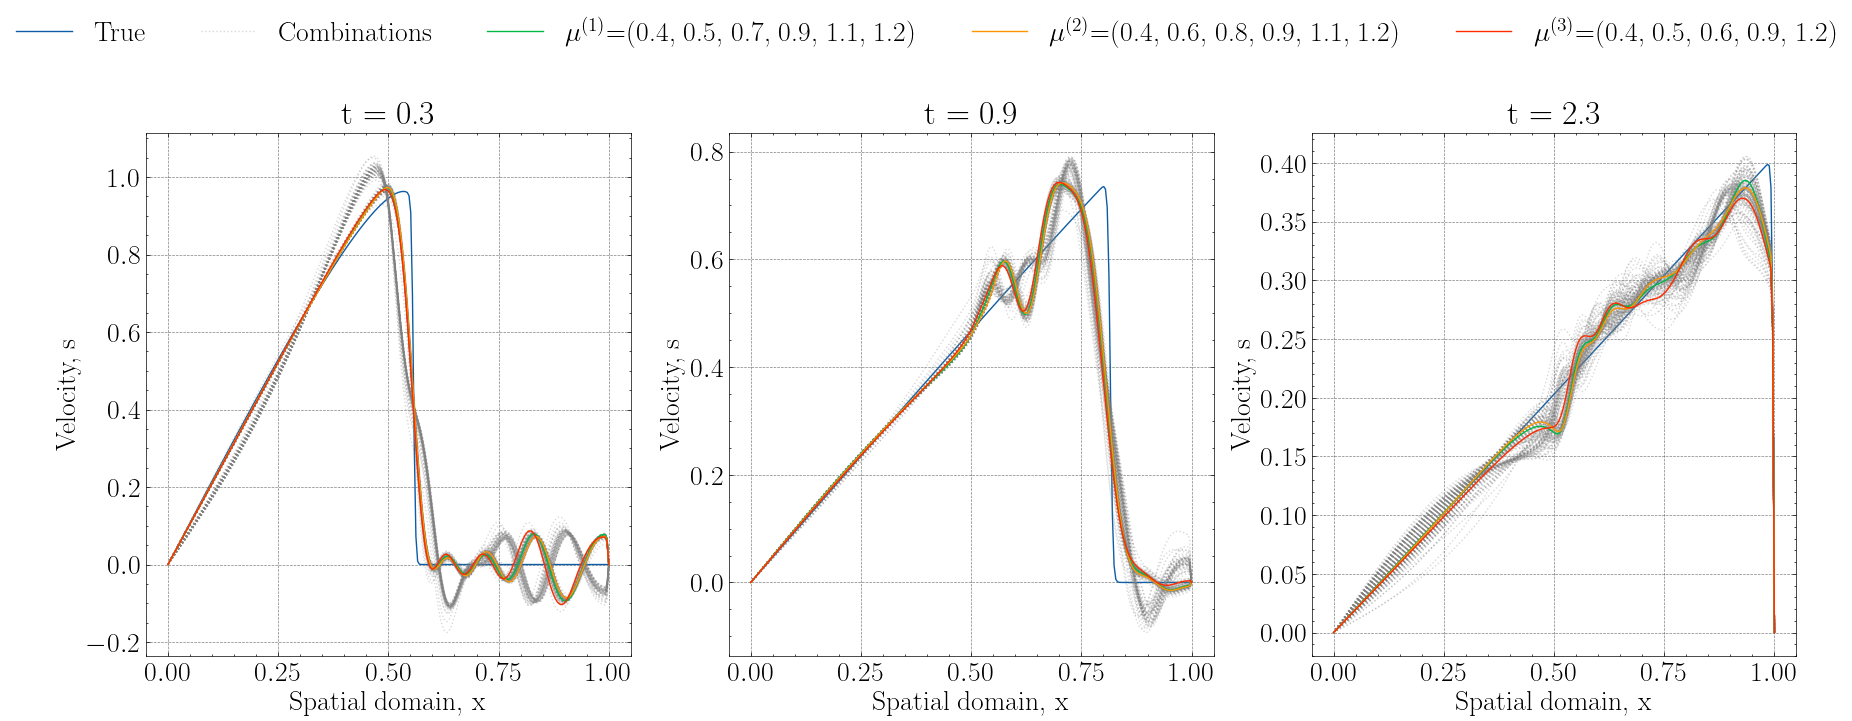

In [58]:
times = [0.3, 0.9, 2.3]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(X_list)))

# Create empty lists to store line objects and labels for the common legend
lines = []
labels = []


names_plot = []
for i in range(len(representatives)):
    names_plot.append(r"$\mu^{(" + f"{i+1}" + ")}$" + f"={drawn_mus[representatives[i]]}")


for i, t in enumerate(times):
    ax = axs[i]
    t_index = int(t / dt)  # Ensure dt is defined and properly calculated
    
    # Main plot
    x_values = np.linspace(0, 1, s_rec_full_lst_operators[0].shape[0])
    line = ax.plot(x_values, X_all_test.T[:, t_index], linestyle='-', alpha=1)[0]
    
    if i == 0:  # Only add to legend for the first subplot
        lines.append(line)
        labels.append("True")
    
    for j in range(len(X_list)-1):
        grey_line = ax.plot(x_values, s_rec_full_lst_operators[j][:, t_index], linestyle=':', alpha=0.3, color='grey')[0]
        
        if i == 0 and j == 0:
            lines.append(grey_line)
            labels.append("Combinations")
        
    for index, j in enumerate(representatives):
            line = ax.plot(x_values, s_rec_full_lst_operators[j][:, t_index], linestyle='-', alpha=1)[0]
            if i == 0:  # Only add to legend for the first subplot
                lines.append(line)
                labels.append(names_plot[index])
    
    ax.set_title(f"t = {t}")
    ax.set_xlabel('Spatial domain, x')
    ax.set_ylabel('Velocity, s')

# Adjust the subplot layout to make room for the legend
plt.tight_layout()

# Add a common legend on top
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
           ncol=len(lines), fancybox=False, shadow=False, edgecolor='None')

# Adjust the figure size to accommodate the legend
fig.set_size_inches(18, 7)  # Increase the height slightly

# plt.show()
plt.savefig("soln_comb_selected_operators_q8_r7.pdf", bbox_inches='tight')

Pairwise Frobenius distances (A):
[[0.         0.23973127 0.3857125  ... 0.75483586 0.83324668 0.74064929]
 [0.23973127 0.         0.23461923 ... 0.64618383 0.73212082 0.63629493]
 [0.3857125  0.23461923 0.         ... 0.50289463 0.5981803  0.52339557]
 ...
 [0.75483586 0.64618383 0.50289463 ... 0.         0.12209883 0.11387919]
 [0.83324668 0.73212082 0.5981803  ... 0.12209883 0.         0.15152936]
 [0.74064929 0.63629493 0.52339557 ... 0.11387919 0.15152936 0.        ]]
Pairwise Spectral distances (A):
[[0.         0.23973127 0.3857125  ... 0.75483586 0.83324668 0.74064929]
 [0.23973127 0.         0.23461923 ... 0.64618383 0.73212082 0.63629493]
 [0.3857125  0.23461923 0.         ... 0.50289463 0.5981803  0.52339557]
 ...
 [0.75483586 0.64618383 0.50289463 ... 0.         0.12209883 0.11387919]
 [0.83324668 0.73212082 0.5981803  ... 0.12209883 0.         0.15152936]
 [0.74064929 0.63629493 0.52339557 ... 0.11387919 0.15152936 0.        ]]


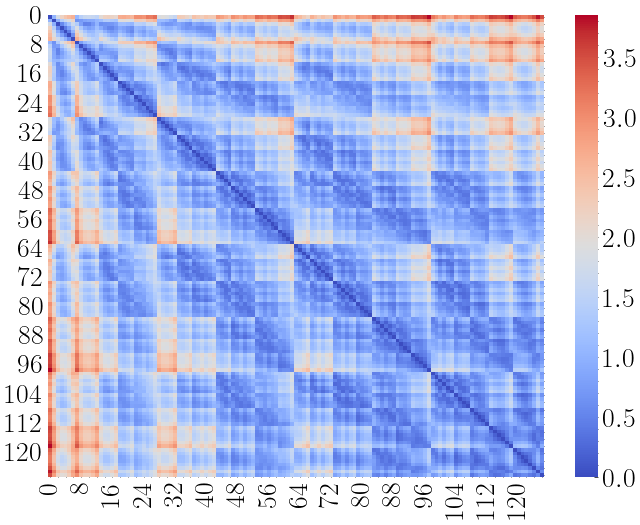

In [18]:
# for each operator compute pairwise difference in terms of Frobenius Norm, Spectral Norm, and Eigenvalue distances

operatorsA = []
operatorsF = []
operatorsC = []
operatorsP = []

# Extract matrices from the dictionaries
for dictionary in operators_lst:
    operatorsA.append(dictionary['A'])
    operatorsF.append(dictionary['F'])
    operatorsC.append(dictionary['C'])
    operatorsP.append(dictionary['P'])


# Function to compute the normalized Frobenius norm difference between two matrices
def frobenius_norm_difference(matrix_a, matrix_b):
    norm_a = np.linalg.norm(matrix_a, 'fro')
    norm_b = np.linalg.norm(matrix_b, 'fro')
    diff_norm = np.linalg.norm(matrix_a - matrix_b, 'fro')
    return diff_norm

# Function to compute the normalized Spectral norm difference between two matrices
def spectral_norm_difference(matrix_a, matrix_b):
    norm_a = np.linalg.norm(matrix_a)
    norm_b = np.linalg.norm(matrix_b)
    diff_norm = np.linalg.norm(matrix_a - matrix_b)
    return diff_norm


def pairwise_mat_distances(matrices, norm_function):
    num_matrices = len(matrices)
    
    # Initialize a 2D array with zeros
    pair_dist = np.zeros((num_matrices, num_matrices))
    
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            matrix_a = matrices[i]
            matrix_b = matrices[j]
            norm_diff = norm_function(matrix_a, matrix_b)
            # Store the norm difference in the pair_dist array
            pair_dist[i][j] = norm_diff
            pair_dist[j][i] = norm_diff  # Since distance is symmetric
            
    
    # normalize the distance matrix
    max_val = np.max(pair_dist)
    min_val = np.min(pair_dist)
    pair_dist = (pair_dist - min_val) / (max_val - min_val)
    return pair_dist

# Calculate pairwise distances for each type of operator and each norm
operatorsA_frobenius = pairwise_mat_distances(operatorsA, frobenius_norm_difference)
operatorsF_frobenius = pairwise_mat_distances(operatorsF, frobenius_norm_difference)
operatorsC_frobenius = pairwise_mat_distances(operatorsC, frobenius_norm_difference)
operatorsP_frobenius = pairwise_mat_distances(operatorsP, frobenius_norm_difference)

operatorsA_spectral = pairwise_mat_distances(operatorsA, spectral_norm_difference)
operatorsF_spectral = pairwise_mat_distances(operatorsF, spectral_norm_difference)
operatorsC_spectral = pairwise_mat_distances(operatorsC, spectral_norm_difference)
operatorsP_spectral = pairwise_mat_distances(operatorsP, spectral_norm_difference)

# Print or process the resulting distance matrices as needed
print("Pairwise Frobenius distances (A):")
print(operatorsA_frobenius)

print("Pairwise Spectral distances (A):")
print(operatorsA_spectral)

# Repeat for F, C, and P as needed


# calculate total frobenius norm of operators
operators_total_frobenius = operatorsA_frobenius + operatorsF_frobenius + operatorsC_frobenius + operatorsP_frobenius

# Create a heatmap to visualize the distance matrix
num_matrices = len(operatorsA)
plt.figure(figsize=(8, 6))
# sns.heatmap(operatorsA_frobenius, annot=True, cmap='coolwarm', xticklabels=[f'Matrix {i+1}' for i in range(num_matrices)], yticklabels=[f'Matrix {i+1}' for i in range(num_matrices)])
sns.heatmap(operators_total_frobenius, cmap='coolwarm')
# plt.title('Total Frobenius Norm Difference Heatmap of Operators')
# plt.title('Total Frobenius Norm Difference')
# plt.show()
plt.savefig("HM_TotalNormFrobDiff.pdf", bbox_inches='tight')

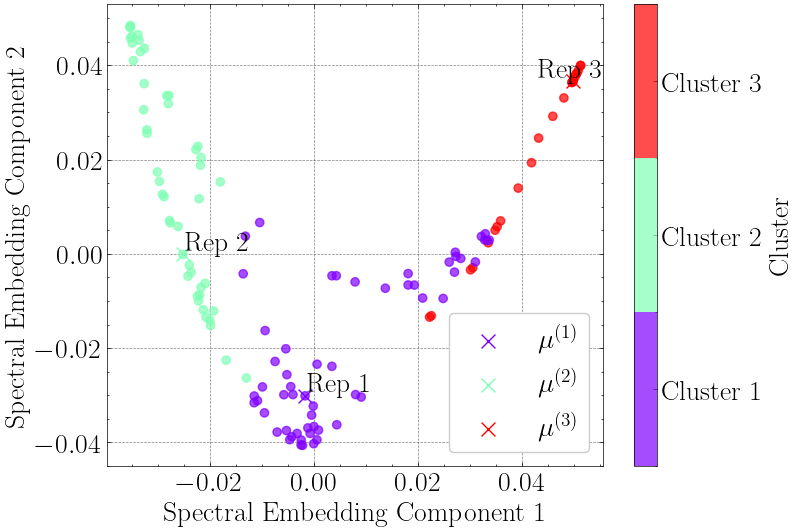

In [19]:
from adjustText import adjust_text
from matplotlib.colors import BoundaryNorm

names_plot = []
for i in range(len(representatives)):
    # names_plot.append(r"$\mu^{(" + f"{i+1}" + ")}$" + f"={drawn_mus[representatives[i]]}")
    names_plot.append(r"$\mu^{(" + f"{i+1}" + ")}$")

# plot the spectral embedding of the V_combined basis colored by the normalized frobenius norm difference
V_combined_embedding = embedder.fit_transform(flat_V_combined_arr.T)

optimal_n_clusters = np.unique(cluster_labels).shape[0]

# Create a colormap with the same number of colors as clusters
cmap = plt.get_cmap('rainbow', optimal_n_clusters)

# Define the boundaries for the discrete color intervals
boundaries = np.arange(optimal_n_clusters + 1) - 0.5
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.7)

# Create a discrete colorbar
cbar = fig.colorbar(scatter, ax=ax, boundaries=boundaries, ticks=np.arange(optimal_n_clusters))
cbar.set_label('Cluster')

# Set the tick labels for the colorbar
cbar.set_ticklabels([f'Cluster {i + 1}' for i in range(optimal_n_clusters)])

# ax.set_title('Spectral Embedding of $[V]$')
texts = []
for i, rep in enumerate(representatives):
    # ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c='black', marker='x', s=100)
    ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c=cluster_labels[rep], cmap=cmap, norm=norm, s=100, marker='x', label=names_plot[i])
    text = ax.annotate(f"Rep {i+1}", (V_combined_embedding[rep, 0], V_combined_embedding[rep, 1]))
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
ax.legend()
ax.set_xlabel('Spectral Embedding Component 1')
ax.set_ylabel('Spectral Embedding Component 2')
# plt.show()
plt.savefig("SE_V_basis_RiemK_Cluster_r7.pdf", bbox_inches='tight')

<>:30: SyntaxWarning: invalid escape sequence '\P'
<>:30: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1194421/98588203.py:30: SyntaxWarning: invalid escape sequence '\P'
  ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c=cluster_labels[rep], cmap=cmap, norm=norm, s=100, marker='x', label=f"$[\Phi^{(i+1)}]$")


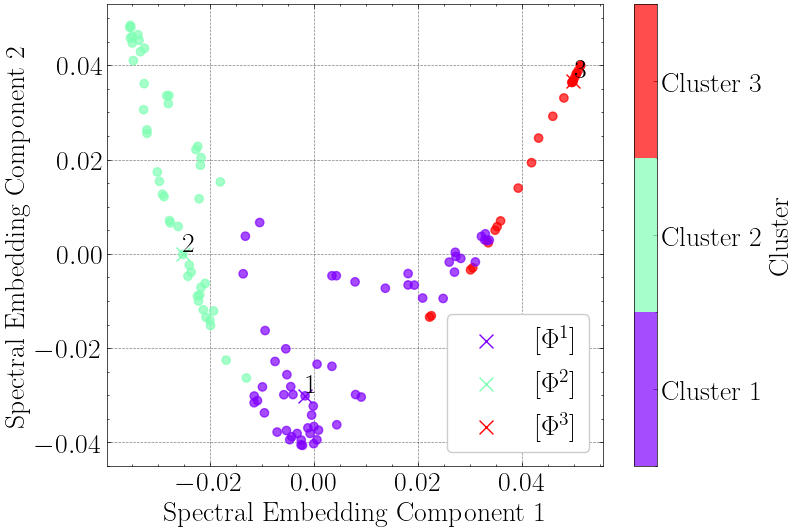

In [20]:
from adjustText import adjust_text
from matplotlib.colors import BoundaryNorm

# plot the spectral embedding of the V_combined basis colored by the normalized frobenius norm difference
V_combined_embedding = embedder.fit_transform(flat_V_combined_arr.T)

optimal_n_clusters = np.unique(cluster_labels).shape[0]

# Create a colormap with the same number of colors as clusters
cmap = plt.get_cmap('rainbow', optimal_n_clusters)

# Define the boundaries for the discrete color intervals
boundaries = np.arange(optimal_n_clusters + 1) - 0.5
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.7)

# Create a discrete colorbar
cbar = fig.colorbar(scatter, ax=ax, boundaries=boundaries, ticks=np.arange(optimal_n_clusters))
cbar.set_label('Cluster')

# Set the tick labels for the colorbar
cbar.set_ticklabels([f'Cluster {i + 1}' for i in range(optimal_n_clusters)])

# ax.set_title('Spectral Embedding of $[V]$')
texts = []
for i, rep in enumerate(representatives):
    # ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c='black', marker='x', s=100)
    ax.scatter(V_combined_embedding[rep, 0], V_combined_embedding[rep, 1], c=cluster_labels[rep], cmap=cmap, norm=norm, s=100, marker='x', label=f"$[\Phi^{(i+1)}]$")
    text = ax.annotate(f"{i + 1}", (V_combined_embedding[rep, 0], V_combined_embedding[rep, 1]))
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
ax.legend()
ax.set_xlabel('Spectral Embedding Component 1')
ax.set_ylabel('Spectral Embedding Component 2')
# plt.show()
plt.savefig("SE_V_basis_RiemK_Cluster_Viz.pdf", bbox_inches='tight')

In [21]:
X_list_sel = [X_list[i] for i in representatives]
mus_sel = [drawn_mus[i] for i in representatives]

In [22]:
# change the names too
names_sel = [names[i] for i in representatives]
names_sel.append("Global")

In [23]:
# custom transform for tensor
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return (tensor - self.mean) / self.std

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [24]:
frechet_mean = calc_frechet_mean_mat(stiefel_samples_combined, V_combined_lst_stochastic[-1], eps=1e-2, tau=1e-3)

Vr_frechet_mean = frechet_mean[0][:, :r]
Vbar_frechet_mean = frechet_mean[0][:, r:+r+q_trunc]

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic

In [25]:
representatives

[77, 90, 30]

<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\P'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:73: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\P'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:73: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1194421/2683956609.py:47: SyntaxWarning: invalid escape sequence '\o'
  plt.scatter(embedding_Vbar[-2, 0], embedding_Vbar[-2, 1], color='purple', label='$[\overline{V}]$ global', marker='x', s=100)
/tmp/ipykernel_1194421/2683956609.py:62: SyntaxWarning: invalid escape sequence '\m'
  plt.scatter(embedding_V_combined[:N_stiefel_samples, 0], embedding_V_combined[:N_stiefel_samples, 1], color=colors[maxI], s=1, label='$[\mathbf{\Phi}]$ samples')
/tmp/ipykernel_1194421/26839

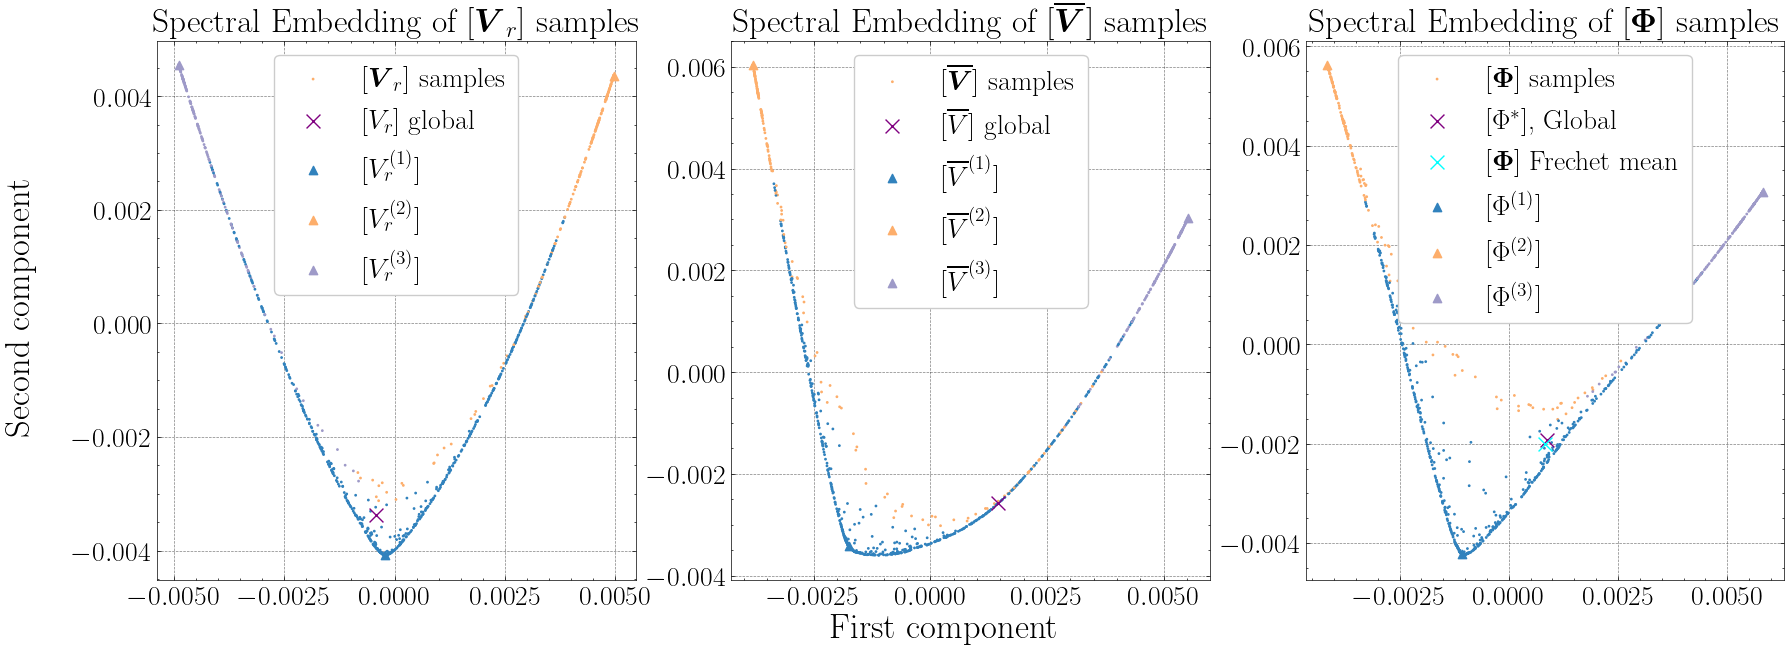

In [26]:
N_stiefel_samples = 1000

# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst_sel], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst_sel], axis=1)
flat_V_combined_arr_stochastic = np.concatenate([rob.flatten()[:, None] for rob in V_combined_lst_stochastic], axis=1)
flat_Vr_frechet_mean = Vr_frechet_mean.flatten()[:, None]
flat_Vbar_frechet_mean = Vbar_frechet_mean.flatten()[:, None]
rob_Vr_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vr] + [flat_Vr_arr] + [flat_Vr_frechet_mean], axis=1)
rob_Vbar_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vbar] + [flat_Vbar_arr] + [flat_Vbar_frechet_mean], axis=1)
rob_V_combined_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_combined] + [flat_V_combined_arr_stochastic] + [frechet_mean[0].flatten()[:, None]], axis=1)

from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst_sel)))

# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(rob_Vr_all.T)
embedding_Vbar = embedder.fit_transform(rob_Vbar_all.T)
embedding_V_combined = embedder.fit_transform(rob_V_combined_all.T)

# Plot the embeddings
fig = plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
# plt.scatter(embedding_Vr[:-2, 0], embedding_Vr[:-2, 1], color='grey', s=1, label='Vr samples')
plt.scatter(embedding_Vr[:N_stiefel_samples, 0], embedding_Vr[:N_stiefel_samples, 1], color=colors[maxI], s=1, label='$[\\boldsymbol{V}_r]$ samples')
plt.scatter(embedding_Vr[-2, 0], embedding_Vr[-2, 1], color='purple', label='$[V_r]$ global', marker='x', s=100)
# plt.scatter(embedding_Vr[-1, 0], embedding_Vr[-1, 1], color='cyan', label='Vr Frechet mean', marker='x', s=100)


for i in range(len(Vr_lst_sel)-1):
    # plt.scatter(embedding_Vr[N_stiefel_samples+i, 0], embedding_Vr[N_stiefel_samples+i, 1], color=colors[i], label=r"$[V_r^{(" + str(i+1) + ")}]$, " + names_sel[i], marker='^')
    plt.scatter(embedding_Vr[N_stiefel_samples+i, 0], embedding_Vr[N_stiefel_samples+i, 1], color=colors[i], label=r"$[V_r^{(" + str(i+1) + ")}]$", marker='^')
    # plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], label=f"Vr {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])

plt.legend()
plt.title(r'Spectral Embedding of $[\boldsymbol{V}_r]$ samples')
# plt.xlabel('First component')
# plt.ylabel('Second component')


plt.subplot(1, 3, 2)
plt.scatter(embedding_Vbar[:N_stiefel_samples, 0], embedding_Vbar[:N_stiefel_samples, 1], color=colors[maxI], s=1, label=r'$[\overline{\boldsymbol{V}}]$ samples')
plt.scatter(embedding_Vbar[-2, 0], embedding_Vbar[-2, 1], color='purple', label='$[\overline{V}]$ global', marker='x', s=100)
# plt.scatter(embedding_Vbar[-1, 0], embedding_Vbar[-1, 1], color='cyan', label='Vbar Frechet mean', marker='x', s=100)

for i in range(len(Vbar_lst_sel)-1):
    # plt.scatter(embedding_Vbar[N_stiefel_samples+i, 0], embedding_Vbar[N_stiefel_samples+i, 1], color=colors[i], label=r"$[\overline{V}^{(" + str(i+1) + ")}]$, " + f"{names_sel[i]}", marker='^')
    plt.scatter(embedding_Vbar[N_stiefel_samples+i, 0], embedding_Vbar[N_stiefel_samples+i, 1], color=colors[i], label=r"$[\overline{V}^{(" + str(i+1) + ")}]$", marker='^')
    # print(f"Vbar {names_sel[-i-1]}")
    # plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], label=f"Vbar {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])
    

plt.legend()
plt.title(r'Spectral Embedding of $[\overline{\boldsymbol{V}}]$ samples')


plt.subplot(1, 3, 3)
plt.scatter(embedding_V_combined[:N_stiefel_samples, 0], embedding_V_combined[:N_stiefel_samples, 1], color=colors[maxI], s=1, label='$[\mathbf{\Phi}]$ samples')
plt.scatter(embedding_V_combined[-2, 0], embedding_V_combined[-2, 1], color='purple', label='$[\Phi^*]$, Global', marker='x', s=100)
plt.scatter(embedding_V_combined[-1, 0], embedding_V_combined[-1, 1], color='cyan', label='$[\mathbf{\Phi}]$ Frechet mean', marker='x', s=100)

for i in range(len(V_combined_lst_stochastic)-1):
    # plt.scatter(embedding_V_combined[N_stiefel_samples+i, 0], embedding_V_combined[N_stiefel_samples+i, 1], color=colors[i], label=r"$[\Phi^{(" + str(i+1) + ")}]$, " + f"{names_sel[i]}", marker='^')
    plt.scatter(embedding_V_combined[N_stiefel_samples+i, 0], embedding_V_combined[N_stiefel_samples+i, 1], color=colors[i], label=r"$[\Phi^{(" + str(i+1) + ")}]$", marker='^')
    # print(f"Vbar {names_sel[-i-1]}")


plt.legend()
plt.title('Spectral Embedding of $[\mathbf{\Phi}]$ samples')
    

# plt.xlabel('First component')
# plt.ylabel('Second component')

# Add common x and y labels
fig.text(0.5, 0.04, 'First component', ha='center', va='center', fontsize=25)
fig.text(0.06, 0.5, 'Second component', ha='center', va='center', rotation='vertical', fontsize=25)
# plt.show()
plt.savefig("SE_StiefelSamples_RiemK_q8_r7.pdf", bbox_inches='tight')

In [27]:
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Normalizers = []

n_epochs = 200

torch.set_float32_matmul_precision('high')

In [28]:
for i in range(len(operators_lst_sel)):
    
    X = X_list_sel[i]
    
    X_ref = np.mean(X, axis=1)[:, None]
    X_centered = X - X_ref

    # U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = Vr_lst_sel[i]
    Vbar = Vbar_lst_sel[i]
    q = Vr.T @ X_centered
    qbar = Vbar.T @ X_centered
    
    # create dataloaders train and val using 80/20 split
    q = torch.from_numpy(q).float().to(device) if isinstance(q, np.ndarray) else q
    qbar = torch.from_numpy(qbar).float().to(device) if isinstance(qbar, np.ndarray) else qbar

    # Split the raw data into training and validation sets
    train_size = int(0.8 * q.shape[1])
    val_size = q.shape[1] - train_size

    q_train, q_val, qbar_train, qbar_val = train_test_split(q.T, qbar.T, train_size=train_size, test_size=val_size, random_state=42)

    # Calculate normalization statistics on the training set
    mean_q = torch.mean(q_train, 0)
    std_q = torch.std(q_train, 0)
    
    Vr = torch.from_numpy(Vr).float().to(device) if isinstance(Vr, np.ndarray) else Vr
    Vbar = torch.from_numpy(Vbar).float().to(device) if isinstance(Vbar, np.ndarray) else Vbar
    X_ref = torch.from_numpy(X_ref).float().to(device) if isinstance(X_ref, np.ndarray) else X_ref
    X = torch.from_numpy(X).float().to(device) if isinstance(X, np.ndarray) else X
    
    Normalizer = Normalize(mean_q, std_q)
    Normalizers.append(Normalizer)

In [29]:
import tqdm

N = 2**8 + 1
N_samples = 1000
abs_error_full_lst = []
relative_error_testing_window_lst = []
relative_error_training_window_lst = []
s_rec_full_lst = []
s_rec_full_Xi_lst = []

mu_test = 0.98

model = Net(r, q_trunc)
model.to(device)
model = torch.compile(model)

for i in tqdm.tqdm(range(N_samples)):
    # # randomly choose 1 from stiefel_samples_Vr and 1 from stiefel_samples_Vbar
    # idx_Vr = np.random.randint(0, N_stiefel_samples)
    # idx_Vbar = np.random.randint(0, N_stiefel_samples)
    
    # print(i)
    
    X = X_list_sel[maxI[i]]
    X_ref = np.mean(X, axis=1)[:, None]
    Normalizer = Normalizers[maxI[i]]
    
    Vr_sample = stiefel_samples_Vr[i]
    Vbar_sample = stiefel_samples_Vbar[i]
    
    operators = operators_lst_sel[maxI[i]]

    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr_sample.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    Nsnapshots = X.shape[1] // len(mus_sel[maxI[i]])
    adjusted_snapshots_per_segment = Nsnapshots - 4  # Adjust for the boundary points lost
    total_adjusted_snapshots = adjusted_snapshots_per_segment * Mp  # Total adjusted snapshots for all segments

    train_size = total_adjusted_snapshots // len(mus_sel[maxI[i]])

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    

    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, config['params'], None, multi_indices],  # additional arguments to rhs
                
            )
    
    s_hat_full = out_full.y
    
    # ----------------- Reconstruct the full state -----------------
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    s_rec_full_Xi = X_ref + Vr_sample @ s_hat_full + Vbar_sample @ Xi_lst_sel[maxI[i]] @ poly_full

    # ----------------- Reconstruct the full state using the neural network -----------------
    model.load_state_dict(torch.load(f"../models/NN_model_{maxI[i]}_r7.pt"))
    
    s_hat_full = torch.from_numpy(s_hat_full).float().to(device)
    Vr_sample = torch.from_numpy(Vr_sample).float().to(device) if isinstance(Vr_sample, np.ndarray) else Vr_sample
    Vbar_sample = torch.from_numpy(Vbar_sample).float().to(device) if isinstance(Vbar_sample, np.ndarray) else Vbar_sample
    X_ref = torch.from_numpy(X_ref).float().to(device) if isinstance(X_ref, np.ndarray) else X_ref
    
    s_rec_full = X_ref + Vr_sample @ s_hat_full + Vbar_sample @ model(Normalizer(s_hat_full.T)).T
    s_rec_full = s_rec_full.cpu().detach().numpy()
    
    
    
    try:
        abs_error_full = np.abs(X_all_test.T - s_rec_full)
        relative_error_testing_window = np.linalg.norm(X_all_test.T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_test.T[:, T_end_index:], 'fro')
        relative_error_training_window = np.linalg.norm(X_all_test.T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_test.T[:, :T_end_index], 'fro')
        
        abs_error_full_lst.append(abs_error_full)
        relative_error_testing_window_lst.append(relative_error_testing_window)
        relative_error_training_window_lst.append(relative_error_training_window)
        s_rec_full_lst.append(s_rec_full)
        s_rec_full_Xi_lst.append(s_rec_full_Xi)
        
    except Exception as e:
        print(e)
        print("Error in iteration: ", i)
        continue    

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_1194421/849946392.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../models/NN

In [30]:
# mean relative error across the testing window
mean_relative_error_testing = np.mean(relative_error_testing_window_lst)
std_relative_error_testing = np.std(relative_error_testing_window_lst)
# coeff_var = std_relative_error_testing / mean_relative_error_testing
print(f"Mean relative error: {mean_relative_error_testing:.4%}")
print(f"Std relative error: {std_relative_error_testing:.4%}")
# print(f"Coefficient of variation: {coeff_var:.4%}")

Mean relative error: 25.8964%
Std relative error: 3.9060%


In [31]:
std_s_rec_full = np.std(s_rec_full_lst, axis=0)
std_s_rec_full_testing = std_s_rec_full[:, T_end_index:]
std_s_rec_full_training = std_s_rec_full[:, :T_end_index]

#  mean reconstruction
mean_s_rec_full = np.mean(s_rec_full_lst, axis=0)
mean_s_rec_full_testing = mean_s_rec_full[:, T_end_index:]
mean_s_rec_full_training = mean_s_rec_full[:, :T_end_index]

# calculate 95% confidence interval
confidence_interval = 1.96 * std_s_rec_full

In [32]:
from scipy import stats
degrees_of_freedom = len(s_rec_full_lst) - 1
confidence_interval_percentile = np.percentile(s_rec_full_lst, [2.5, 97.5], axis=0)

In [71]:
std_s_rec_full_Xi = np.std(s_rec_full_Xi_lst, axis=0)
mean_s_rec_full_Xi = np.mean(s_rec_full_Xi_lst, axis=0)
# confidence_interval_Xi = 1.96 * std_s_rec_full_Xi 
confidence_interval_Xi_percentile = np.percentile(s_rec_full_Xi_lst, [2.5, 97.5], axis=0)

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1194421/2720171422.py:19: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_title(f'True state for $\mu$ = 0.98')


X =  (8000, 257)
Y =  (8000, 257)
s_ref_all[i] =  (257, 6000)


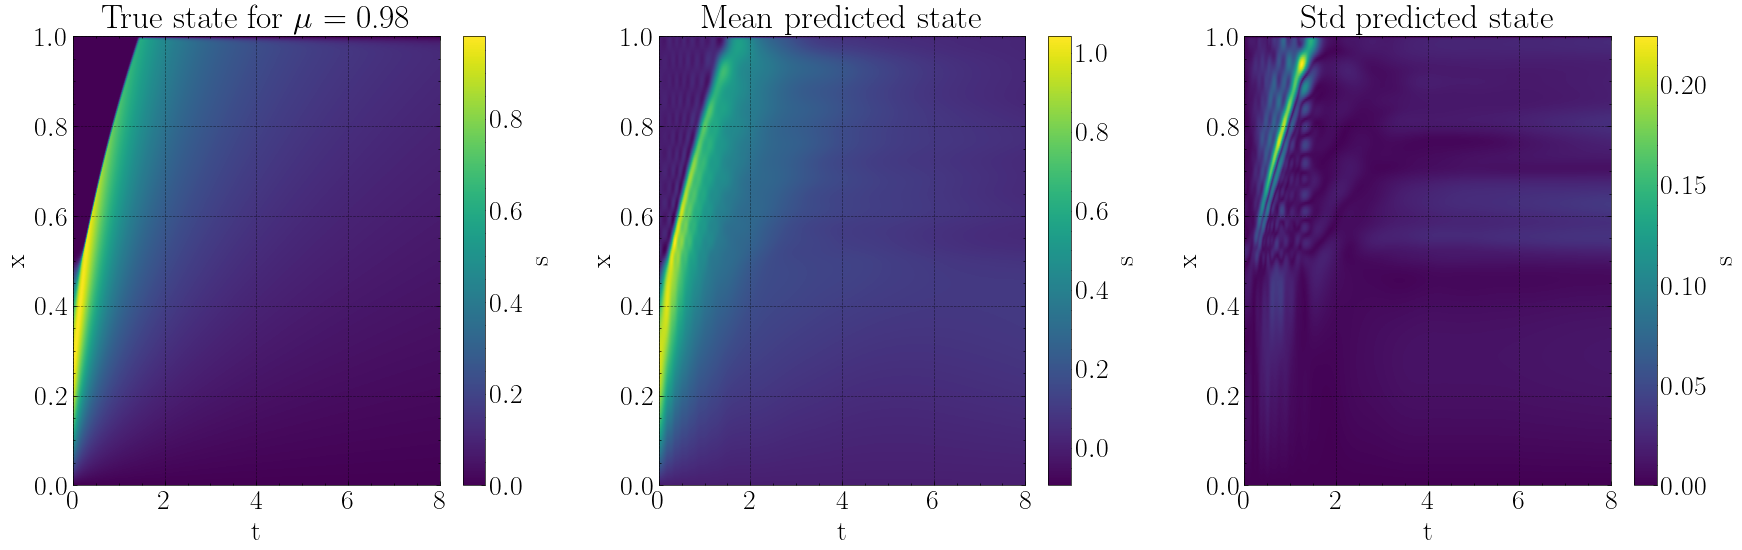

In [34]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(mean_s_rec_full.shape[0])), np.linspace(0.0, 1.0, mean_s_rec_full.shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", mean_s_rec_full_testing.shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    
    c0 = axs[0].imshow(X_all_test.T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c0, ax=axs[0], orientation='vertical', label='s')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'True state for $\mu$ = 0.98')
    
    c1 = axs[1].imshow(mean_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c1, ax=axs[1], orientation='vertical', label='s')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Mean predicted state')
    
    c2 = axs[2].imshow(std_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    fig.colorbar(c2, ax=axs[2], orientation='vertical', label='s')
    axs[2].set_xlabel('t')
    axs[2].set_ylabel('x')
    axs[2].set_title(f'Std predicted state')
    
    
    # fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # fig.colorbar(c2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # plt.suptitle(f"RE1000, IC $\mu$ = 0.98, r={r}, q={q_trunc}, p={p}")
    plt.tight_layout()
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1194421/550549352.py:9: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_title(f'True state for $\mu$ = 0.98')


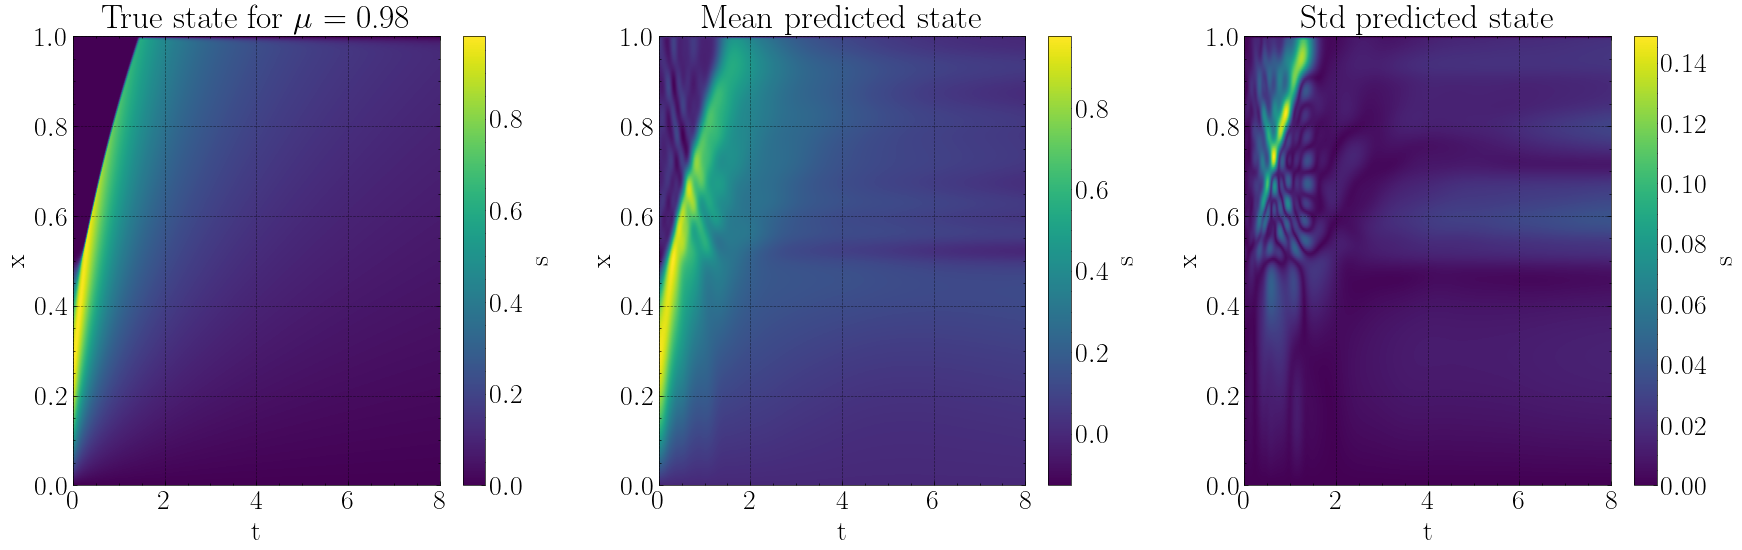

In [35]:
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(mean_s_rec_full.shape[0])), np.linspace(0.0, 1.0, mean_s_rec_full.shape[1]))
    
    c0 = axs[0].imshow(X_all_test.T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c0, ax=axs[0], orientation='vertical', label='s')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'True state for $\mu$ = 0.98')
    
    c1 = axs[1].imshow(mean_s_rec_full_Xi, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c1, ax=axs[1], orientation='vertical', label='s')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Mean predicted state')
    
    c2 = axs[2].imshow(std_s_rec_full_Xi, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    fig.colorbar(c2, ax=axs[2], orientation='vertical', label='s')
    axs[2].set_xlabel('t')
    axs[2].set_ylabel('x')
    axs[2].set_title(f'Std predicted state')
    
    
    # fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # fig.colorbar(c2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # plt.suptitle(f"RE1000, IC $\mu$ = 0.98, r={r}, q={q_trunc}, p={p}")
    plt.tight_layout()
    plt.show()

In [36]:
uncertainty_indices

[657, 714, 2300]

In [64]:
import tqdm

abs_error_full_lst_operators = []
relative_error_testing_window_lst_operators = []
relative_error_training_window_lst_operators = []
s_rec_full_lst_operators_selected = []
s_rec_full_Xi_lst_operators_selected = []

mu_test = 0.98

for i in tqdm.tqdm(range(len(operators_lst_sel))):
    
    operators = operators_lst_sel[i]
    
    X = X_list_sel[i]
    X_ref = np.mean(X, axis=1)[:, None]
    
    Vr = Vr_lst_sel[i]
    Vbar = Vbar_lst_sel[i]
    
    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    Nsnapshots = X.shape[1] // len(mus_sel[maxI[i]])
    adjusted_snapshots_per_segment = Nsnapshots - 4  # Adjust for the boundary points lost
    total_adjusted_snapshots = adjusted_snapshots_per_segment * Mp  # Total adjusted snapshots for all segments

    train_size = total_adjusted_snapshots // len(mus_sel[maxI[i]])

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, config['params'], None, multi_indices],  # additional arguments to rhs
            )
    
    s_hat_full = out_full.y
    
    s_rec_full_Xi = X_ref + Vr @ s_hat_full + Vbar @ Xi_lst_sel[i] @ np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    
    model.load_state_dict(torch.load(f"../models/NN_model_{maxI[i]}_r7.pt"))
    
    s_hat_full = torch.from_numpy(s_hat_full).float().to(device)
    Vr = torch.from_numpy(Vr).float().to(device) if isinstance(Vr, np.ndarray) else Vr
    Vbar = torch.from_numpy(Vbar).float().to(device) if isinstance(Vbar, np.ndarray) else Vbar
    X_ref = torch.from_numpy(X_ref).float().to(device) if isinstance(X_ref, np.ndarray) else X_ref
    
    s_rec_full = X_ref + Vr @ s_hat_full + Vbar @ model(Normalizer(s_hat_full.T)).T
    
    s_rec_full = s_rec_full.cpu().detach().numpy()    
    
    abs_error_full = np.abs(X_all_test.T - s_rec_full)
    relative_error_testing_window = np.linalg.norm(X_all_test.T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_test.T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_test.T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_test.T[:, :T_end_index], 'fro')
    
    abs_error_full_lst_operators.append(abs_error_full)
    relative_error_testing_window_lst_operators.append(relative_error_testing_window)
    relative_error_training_window_lst_operators.append(relative_error_training_window)
    s_rec_full_lst_operators_selected.append(s_rec_full)   
    s_rec_full_Xi_lst_operators_selected.append(s_rec_full_Xi)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_1194421/3414622448.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../models/NN_m

In [65]:
standard_error = std_s_rec_full / np.sqrt(N_samples)
np.allclose(confidence_interval_percentile[1], mean_s_rec_full + stats.t.ppf((1 - 0.95) / 2, degrees_of_freedom) * standard_error, atol=1e-2)

False

In [66]:
mean_s_rec_full + stats.t.ppf((1 - 0.95) / 2, degrees_of_freedom) * standard_error

array([[1.9241730e-15, 1.9113292e-15, 1.8984181e-15, ..., 2.2786994e-16,
        2.2792137e-16, 2.2798466e-16],
       [2.1263745e-02, 2.1224657e-02, 2.1185178e-02, ..., 1.2162954e-03,
        1.2165022e-03, 1.2167355e-03],
       [4.2518787e-02, 4.2440586e-02, 4.2361766e-02, ..., 2.4324679e-03,
        2.4328842e-03, 2.4333487e-03],
       ...,
       [1.0618896e-02, 1.0045002e-02, 9.4697783e-03, ..., 2.5868630e-02,
        2.5866549e-02, 2.5863238e-02],
       [1.1158808e-02, 1.0657187e-02, 1.0154244e-02, ..., 1.6923612e-02,
        1.6922090e-02, 1.6919481e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

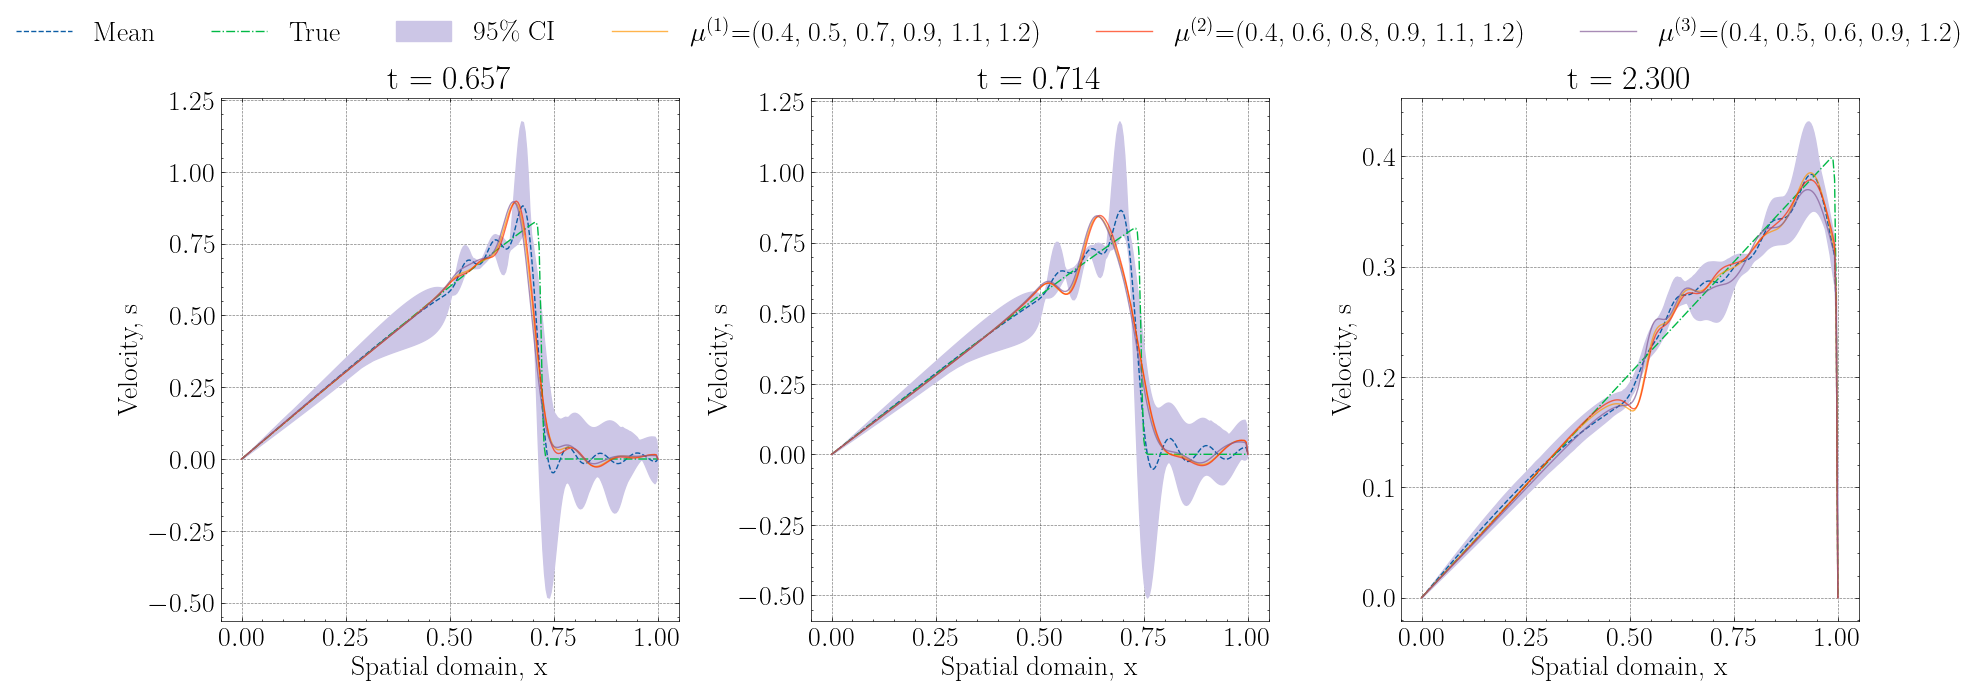

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Example setup (you'll need to define mean_s_rec_full, lower_bound, and upper_bound appropriately)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# upper_bound = mean_s_rec_full + confidence_interval
# lower_bound = mean_s_rec_full - confidence_interval

upper_bound = confidence_interval_percentile[1]
lower_bound = confidence_interval_percentile[0]

# standard_error = std_s_rec_full / np.sqrt(N_samples)
# upper_bound = mean_s_rec_full + stats.t.ppf((1 - 0.95) / 2, degrees_of_freedom) * standard_error
# lower_bound = mean_s_rec_full + stats.t.ppf((1 + 0.95) / 2, degrees_of_freedom) * standard_error

s_rec_full_lst_operators_sel = [s_rec_full_Xi_lst_operators_selected[i] for i in range(len(s_rec_full_Xi_lst_operators_selected))]

# Create empty lists to store line objects and labels for the common legend
lines = []
labels = []

for i, index in enumerate(uncertainty_indices):
    ax = axs[i]
    t_index = index
    t = t_index * dt

    # Main plot
    x_values = np.linspace(0, 1, mean_s_rec_full.shape[0])
    mean_line = mean_s_rec_full[:, t_index]
    true_line = X_all_test.T[:, t_index]
    lower_line = lower_bound[:, t_index]
    upper_line = upper_bound[:, t_index]
    model_lines = [s_rec_full_lst_operators_sel[j][:, t_index] for j in range(len(s_rec_full_lst_operators_sel))]

    mean_plot, = ax.plot(x_values, mean_line, linestyle="--")
    true_plot, = ax.plot(x_values, true_line, linestyle="-.")
    
    darker_lavender = (0.8, 0.775, 0.9) 
    ci_plot = ax.fill_between(x_values, lower_line, upper_line, alpha=1.0, color=darker_lavender)
    # ci_plot = ax.fill_between(x_values, lower_line, upper_line, alpha=1, color='lavender')

    if i == 0:
        lines.extend([mean_plot, true_plot, ci_plot])
        labels.extend(['Mean', 'True', r'95\% CI'])

    for j, model_line in enumerate(model_lines):
        model_plot, = ax.plot(x_values, model_line, linestyle="-", alpha=0.7)
        if i == 0:
            lines.append(model_plot)
            labels.append(names_plot[j])

    ax.set_title(f"t = {t:.3f}")
    ax.set_xlabel('Spatial domain, x')
    ax.set_ylabel('Velocity, s')

# Adjust the subplot layout to make room for the legend
plt.tight_layout()

# Add a common legend on top
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=len(lines), fancybox=False, shadow=False, edgecolor='None')

# Adjust the figure size to accommodate the legend
fig.set_size_inches(18, 7)  # Increase the height slightly

# plt.show()
plt.savefig("CI_solution_q8_r7.pdf", bbox_inches='tight')


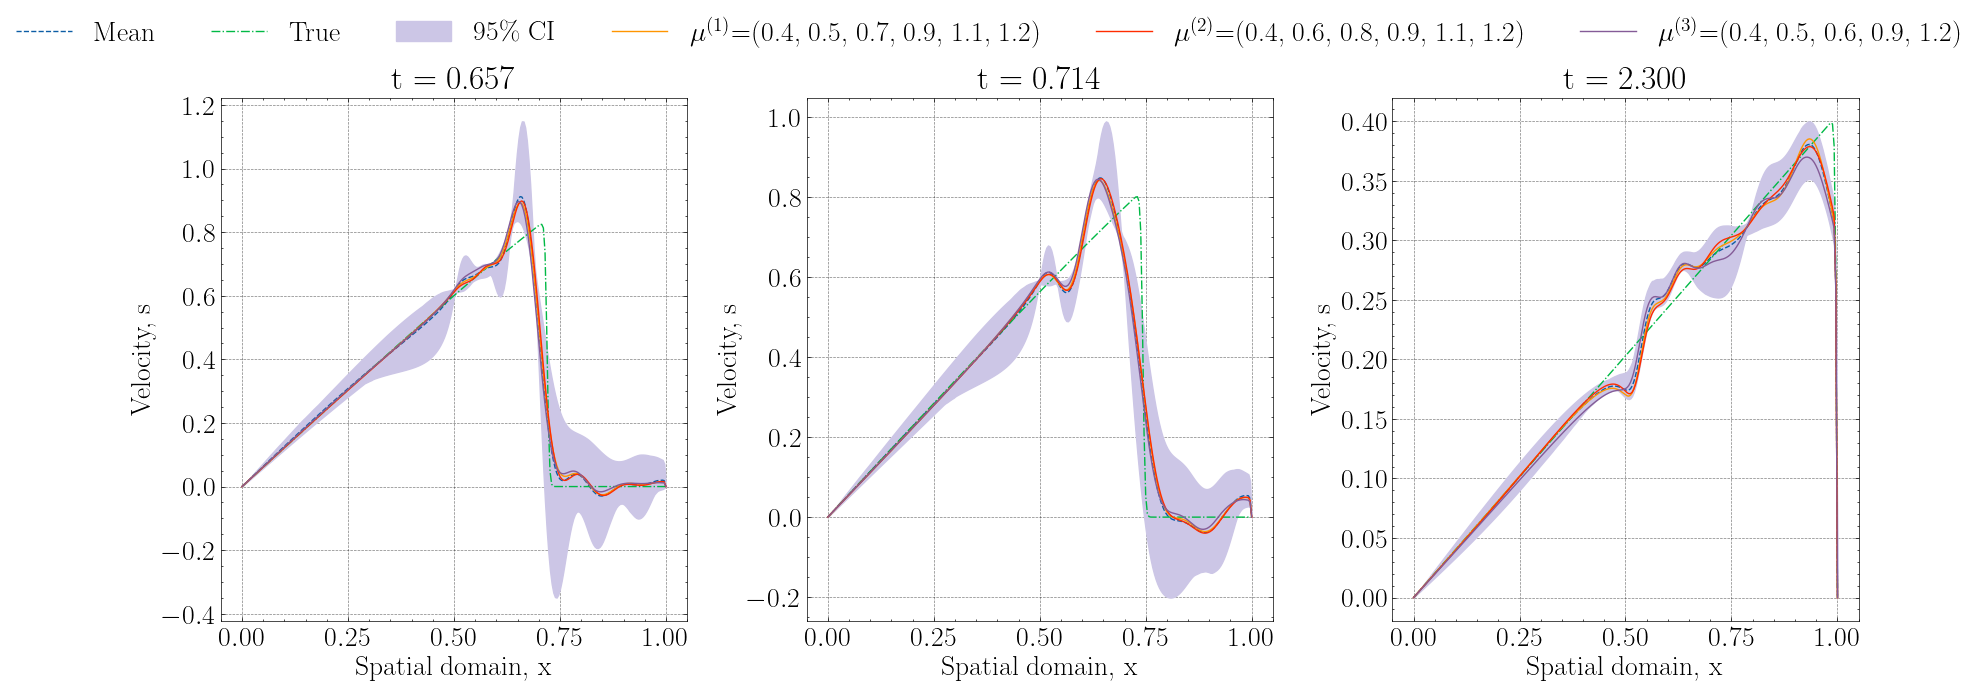

<Figure size 350x262.5 with 0 Axes>

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# upper_bound_Xi = mean_s_rec_full_Xi + confidence_interval_Xi
# lower_bound_Xi = mean_s_rec_full_Xi - confidence_interval_Xi
upper_bound_Xi = confidence_interval_Xi_percentile[1]
lower_bound_Xi = confidence_interval_Xi_percentile[0]

s_rec_full_lst_operators_sel_Xi = [s_rec_full_Xi_lst_operators_selected[i] for i in range(len(s_rec_full_Xi_lst_operators_selected))]

# Create empty lists to store line objects and labels for the common legend
lines = []
labels = []

# for i, t in enumerate(times):
for i, index in enumerate(uncertainty_indices):
    ax = axs[i]
    # t_index = int(t / dt)  # Ensure dt is defined and properly calculated
    t_index = index
    
    t = t_index * dt

    # Main plot
    x_values = np.linspace(0, 1, mean_s_rec_full_Xi.shape[0])
    mean_line = mean_s_rec_full_Xi[:, t_index]
    # nominal_line = s_rec_full_nominal[:, t_index]
    true_line = X_all_test.T[:, t_index]
    lower_line = lower_bound_Xi[:, t_index]
    upper_line = upper_bound_Xi[:, t_index]
    
    model_lines = [s_rec_full_lst_operators_sel_Xi[j][:, t_index] for j in range(len(s_rec_full_lst_operators_sel_Xi))]
    
    # ax.plot(x_values, mean_line, label='Mean', linestyle="--")
    # ax.plot(x_values, true_line, label='True', linestyle="-.")
    # for j in range(len(s_rec_full_lst_operators_sel)):
    #     ax.plot(x_values, model_lines[j], label=names_sel[j], linestyle="-", alpha=0.7)
    # # ax.plot(x_values, nominal_line, label='Nominal', linestyle=":")
    # ax.fill_between(x_values, lower_line, upper_line, alpha=1, label='95% CI', color='lavender')
    
    mean_plot, = ax.plot(x_values, mean_line, linestyle="--")
    true_plot, = ax.plot(x_values, true_line, linestyle="-.")
    
    darker_lavender = (0.8, 0.775, 0.9) 
    ci_plot = ax.fill_between(x_values, lower_line, upper_line, alpha=1.0, color=darker_lavender)

    if i == 0:
        lines.extend([mean_plot, true_plot, ci_plot])
        labels.extend(['Mean', 'True', r'95\% CI'])

    for j, model_line in enumerate(model_lines):
        model_plot, = ax.plot(x_values, model_line, linestyle="-", alpha=1.0)
        if i == 0:
            lines.append(model_plot)
            labels.append(names_plot[j])

    ax.set_title(f"t = {t:.3f}")
    ax.set_xlabel('Spatial domain, x')
    # ax.set_ylabel('u')
    ax.set_ylabel('Velocity, s')
    # ax.legend(loc="best")

plt.tight_layout()
# plt.suptitle(f"Confidence interval for 1000 samples of Vr and Vbar, RE1000, IC $\mu$ = 0.98, r={r}, q={q_trunc}, p={p}")
# * q_trunc = 8, p = 2, r = 8 (for error tolerance 5e-2)

# Add a common legend on top
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=len(lines), fancybox=False, shadow=False, edgecolor='None')

# Adjust the figure size to accommodate the legend
fig.set_size_inches(18, 7)  # Increase the height sligh

plt.show()
plt.savefig("CI_solution_q8_r7_NN.pdf", bbox_inches='tight')


S =  [254.61423941 168.70028869 143.80388294  99.38588662  71.87538159]
idx =  8
rel_err_SVD[idx] =  0.03292343692899835
S =  [262.57825652 168.03575489 139.75562298 102.10745247  74.26797247]
idx =  8
rel_err_SVD[idx] =  0.03405176636571439
S =  [212.14232436 144.25896545 125.21703469  84.40725687  61.34536439]
idx =  7
rel_err_SVD[idx] =  0.038974441606581145
S =  [422.86420145 279.17314277 239.56848262 165.71665135 120.21563063]
idx =  8
rel_err_SVD[idx] =  0.032850098780089265


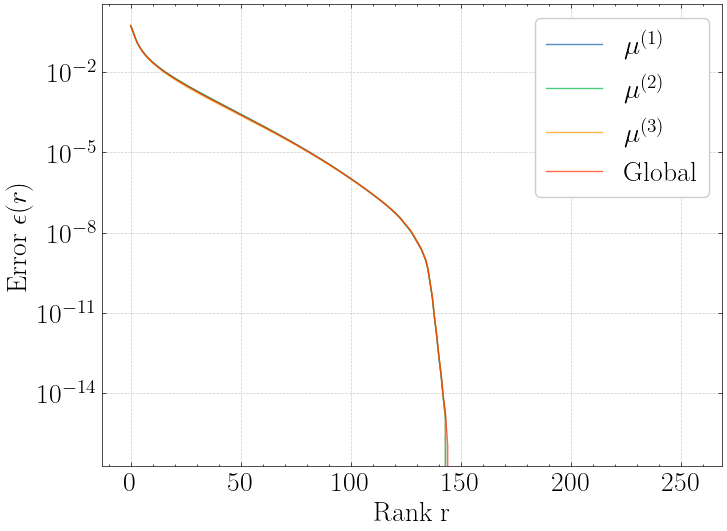

In [39]:
X_all_global = np.concatenate([X_list[i] for i in representatives], axis=1)
X_all_global = X_all_global - np.mean(X_all_global, axis=1)[:, None]

idx_lst = []
rel_err_SVD_lst = []
fig, ax = plt.subplots(figsize=(8, 6))

# SVD to analyze the error function
for i in range(len(representatives)):
    
    X = X_list[representatives[i]]
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names_plot[i], linestyle='-', alpha=0.7)
    # ax.plot(idx, rel_err_SVD[idx], label=f"{err_tol:.2e} at r={idx}, {names[i]}")
    ax.set_yscale('log')
    ax.set_ylabel("$\\epsilon$ (log scale)")
    # set limit
    # ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    # ax.set_title("Relative error, RE1000")
    # ax.legend()
    
U, S, V = np.linalg.svd(X_all_global, full_matrices=False)
print("S = ", S[:5])
eigvals_SVD = S**2 * (1 / (len(S) - 1))

rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
rel_err_SVD_lst.append(rel_err_SVD)

idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
idx_lst.append(idx)
print("idx = ", idx)
print("rel_err_SVD[idx] = ", rel_err_SVD[idx])

ax.plot(rel_err_SVD_lst[-1], label="Global", linestyle='-', alpha=0.7)
# ax.plot(idx, rel_err_SVD[idx], label=f"{err_tol:.2e} at r={idx}, Global")
ax.set_yscale('log')
ax.set_ylabel("Error $\\epsilon(r)$")
ax.grid(True, alpha=0.2)
ax.set_xlabel("Rank r")
# ax.set_title("Relative error, RE1000")

ax.legend()


plt.savefig("errorFunc_Global_r7.pdf", bbox_inches='tight')